Latencia média =  24.622572776610042


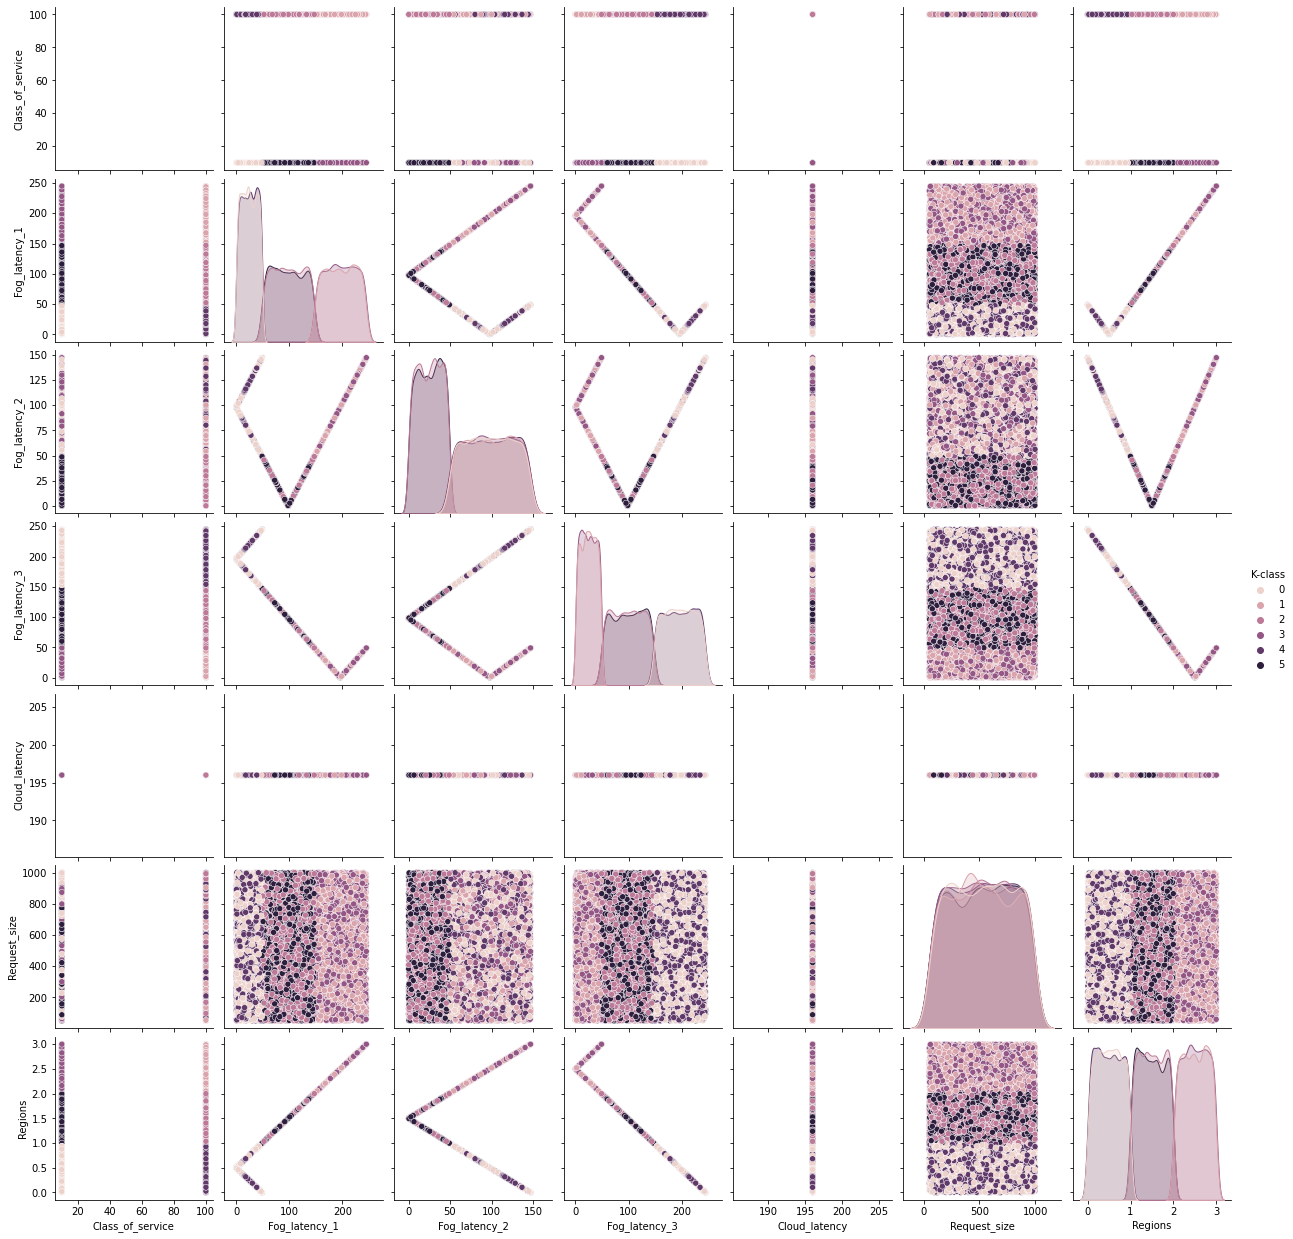

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import json
import math
from sklearn.cluster import KMeans

list_of_devices = []

f = open('workload2.json')
data = json.load(f)



for i in data:
    for t in data[i]:

        device = []
        device.append(i)
        device.append(t['device_id'])
        device.append(10 if t['class_of_service'] == 'standard' else 100)
        device.append(t['latency'][0])
        device.append(t['latency'][1])
        device.append(t['latency'][2])
        device.append(t['latency'][3])
        device.append(t['request_size'])
        device.append(t['region'])

        list_of_devices.append(device)

devicesDf = pd.DataFrame(list_of_devices, columns=['Hour', 'Device_id', 'Class_of_service', 'Fog_latency_1', 'Fog_latency_2','Fog_latency_3', 'Cloud_latency', 'Request_size', 'Regions'])

df_by_hour = devicesDf.groupby('Hour')

#Cada coluna 'dropada' é uma coluna que não vai entrar no kmeans
X = np.array(devicesDf.drop(['Device_id', 'Request_size'], axis = 1))

#aplicação do kmeans
kmeans = KMeans(n_clusters=6, init= 'k-means++',n_init = 10, max_iter = 10000)
kmeans.fit_predict(X)

kmeans.labels_
devicesDf['K-class'] = kmeans.labels_
devicesDf

sum_smallest_latency = 0

for index in range(len(devicesDf)):
    smallest_latency = min([devicesDf["Fog_latency_1"].iloc[index], devicesDf["Fog_latency_2"].iloc[index], devicesDf["Fog_latency_3"].iloc[index]])
    sum_smallest_latency += smallest_latency

media_latency = sum_smallest_latency / devicesDf.shape[0]

print("Latencia média = ", media_latency)

sb.pairplot(devicesDf, hue="K-class")

<h1>ploting line graph standard and priority workload by time</h1>

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Horário =  0
quantidade dispositivos prioritarios =  9
quantidade dispositivos standard =  9
Menor latencia media =  13.149953746195827
latencia média por CoS =  111.14995374619583
Horário =  1
quantidade dispositivos prioritarios =  18
quantidade dispositivos standard =  18
Menor latencia media =  11.640422143976792
latencia média por CoS =  109.64042214397679
Horário =  2
quantidade dispositivos prioritarios =  35
quantidade dispositivos standard =  35
Menor latencia media =  11.508946725060758
latencia média por CoS =  109.50894672506077
Horário =  3
quantidade dispositivos prioritarios =  64
quantidade dispositivos standard =  64
Menor latencia media =  11.48944190540763
latencia média por CoS =  109.48944190540763
Horário =  4
quantidade dispositivos prioritarios =  108
quantidade dispositivos standard =  108
Menor latencia media =  11.432733934707635
latencia média por CoS =  109.43273393470763

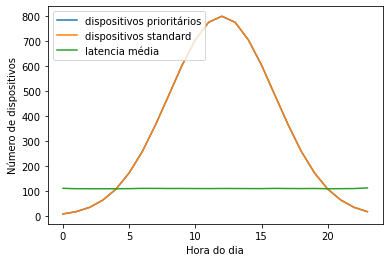

In [2]:
from cProfile import label
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import json
import math
from sklearn.cluster import KMeans

list_of_devices = []

f = open('workload2.json')
data = json.load(f)

for i in data:
    for t in data[i]:

        device = []
        device.append(i)
        device.append(t['device_id'])
        device.append(10 if t['class_of_service'] == 'standard' else 100)
        device.append(t['latency'][0])
        device.append(t['latency'][1])
        device.append(t['latency'][2])
        device.append(t['latency'][3])
        device.append(t['request_size'])
        device.append(t['region'])

        list_of_devices.append(device)

devicesDf = pd.DataFrame(list_of_devices, columns=['Hour', 'Device_id', 'Class_of_service', 'Fog_latency_1', 'Fog_latency_2','Fog_latency_3', 'Cloud_latency', 'Request_size', 'Regions'])
    
df_by_hour = dict(tuple(devicesDf.groupby('Hour')))
print(list(range(len(df_by_hour))))

latency_list_by_priority = []
num_priority_by_hour = []
num_standard_by_hour = []

for i in range(len(df_by_hour)):
    print("Horário = ", i)
    sum_smallest_latency = 0
    num_priority = 0
    num_standard = 0
    latency_by_priority = 0

    for index in range(len(df_by_hour[str(i)])):
        if df_by_hour[str(i)]['Class_of_service'].iloc[index] == 100:
            smallest_latency = min([df_by_hour[str(i)]["Fog_latency_1"].iloc[index], df_by_hour[str(i)]["Fog_latency_2"].iloc[index], df_by_hour[str(i)]["Fog_latency_3"].iloc[index]])
            sum_smallest_latency += smallest_latency
            num_priority += 1
            latency_by_priority += smallest_latency
        else:
            num_standard += 1
            latency_by_priority += df_by_hour[str(i)]['Cloud_latency'].iloc[index]

    media_priority_latency = latency_by_priority / df_by_hour[str(i)].shape[0]
    media_smallest_latency = sum_smallest_latency / df_by_hour[str(i)].shape[0]
    X = np.array(df_by_hour[str(i)].drop(['Device_id', 'Hour', 'Request_size'], axis = 1))

    #aplicação do kmeans
    kmeans = KMeans(n_clusters=6, init= 'k-means++',n_init = 10, max_iter = 10000)
    kmeans.fit_predict(X)

    df_by_hour[str(i)]['K-class'] = kmeans.labels_

    print("quantidade dispositivos prioritarios = ", num_priority)
    print("quantidade dispositivos standard = ", num_standard)

    print("Menor latencia media = ", media_smallest_latency)
    print("latencia média por CoS = ", media_priority_latency)

    latency_list_by_priority.append(media_priority_latency)
    num_priority_by_hour.append(num_priority)
    num_standard_by_hour.append(num_standard)

pl.plot(list(range(len(df_by_hour))), num_priority_by_hour, label="dispositivos prioritários")
pl.plot(list(range(len(df_by_hour))), num_standard_by_hour, label="dispositivos standard")
pl.plot(list(range(len(df_by_hour))), latency_list_by_priority, label="latencia média")
pl.xlabel("Hora do dia")
pl.ylabel("Número de dispositivos")
pl.legend(['dispositivos prioritários', 'dispositivos standard', 'latencia média'])
pl.show()

## Function: alocation_by_priority<br>
Devices alocation based on priority of execution.<br>
Priority devices are connected to the fog nodes and standard devices are connected to the cloud processing node.

### Input:
> devices_regions : list [regions][devices]<br> 
> processing_nodes : list [fog and cloud nodes]<br>

### Return:
> latency_by_priority : float [all latency values from that specific alocation]<br>
> num_priority : int [number of priority devices]<br>
> num_standard : int [number of standard devices]<br>

In [3]:
def alocation_by_priority(devices_regions, processing_nodes):
    latency_by_priority = 0
    standard_latency = 0
    num_priority = 0
    num_standard = 0
    package_size = 1966*(10**6)
    data_link_capacity = 10 * (10**9)
    transmission_latency = package_size / data_link_capacity

    for region in range(len(devices_regions)):
        for index in range(len(devices_regions[region])):
            # verify the priority and the availability of the fog node
            if devices_regions[int(region)][index]["Class_of_service"] == 100 and len(processing_nodes[int(region)].connected_devices) < processing_nodes[int(region)].device_capacity:
                processing_nodes[region].connected_devices.append(
                    devices_regions[region][index])
                #fog_node_id = "Fog_latency_" + str(region+1)
                #latency_by_priority += devices_regions[region][index][fog_node_id]
                #num_priority += 1
            else:
                processing_nodes[-1].connected_devices.append(
                    devices_regions[region][index])
                #if devices_regions[region][index]["Class_of_service"] == 100:
                #    latency_by_priority += devices_regions[region][index]["standard_latency"]
                #else:
                #    standard_latency += devices_regions[region][index]["standard_latency"]
                #num_standard += 1

    for region in range(len(processing_nodes)):
        for devices in processing_nodes[region].connected_devices:
            fog_node_id = "Fog_latency_" + str(region+1)
            if devices["Class_of_service"] == 100:
                num_priority += 1
                if region == 3:
                    latency_by_priority += devices["Cloud_latency"] + transmission_latency
                else:
                    latency_by_priority += devices[fog_node_id] + transmission_latency
            elif devices["Class_of_service"] == 10:
                num_standard += 1
                if region == 3:
                    standard_latency += devices["Cloud_latency"] + transmission_latency
                else:
                    standard_latency += devices[fog_node_id] + transmission_latency
    
    return latency_by_priority, standard_latency, num_priority, num_standard

## Function: fog_first_alocation<br>
Fog first alocation aims to use all capacity of the fog nodes before starts to use the cloud processing node.<br>
Devices that are standard and are connected to the fog node can be relocated to the cloud if a priority user needs to processed in the fog node.

### Input:
> devices_regions : list [regions][devices]<br> 
> processing_nodes : list [fog and cloud nodes]<br>

### Return:
> latency_by_priority : float [all latency values from that specific alocation]<br>
> num_priority : int [number of priority devices]<br>
> num_standard : int [number of standard devices]<br>

In [4]:
def fog_first_alocation(devices_regions, processing_nodes):
    latency_by_priority = 0
    standard_latency = 0
    num_priority = 0
    num_standard = 0
    package_size = 1966*(10**6) # 1966Mb
    data_link_capacity = 10 * (10**9) # 10Gbps
    transmission_latency = package_size / data_link_capacity
    
    for region in range(len(devices_regions)):
        for index in range(len(devices_regions[region])):
            # verify the priority and the availability of the fog node
            fog_node_id = "Fog_latency_" + str(region+1)
            if len(processing_nodes[region].connected_devices) < processing_nodes[region].device_capacity:
                processing_nodes[region].connected_devices.append(
                    devices_regions[region][index])
            else:
                # search for no_priority device connected to fog node
                non_priority_in_fog = False
                for device_index in range(len(processing_nodes[region].connected_devices)):
                    if processing_nodes[region].connected_devices[device_index]["Class_of_service"] == 10:
                        non_priority_in_fog = True
                        no_priority_device = processing_nodes[region].connected_devices[device_index]
                        
                        # disconnect device from fog node
                        processing_nodes[region].connected_devices.pop(device_index)
                        
                        # connect no-priority device on cloud node    
                        processing_nodes[-1].connected_devices.append(
                            no_priority_device)

                        # connect new priority device on the fog node
                        processing_nodes[region].connected_devices.append(devices_regions[region][index])
                        break
                # if no no-priority device is found, just connect to the cloud
                if non_priority_in_fog == False:
                    processing_nodes[-1].connected_devices.append(
                        devices_regions[region][index])

    for region in range(len(processing_nodes)):
        for devices in processing_nodes[region].connected_devices:
            fog_node_id = "Fog_latency_" + str(region+1)
            if devices["Class_of_service"] == 100:
                num_priority += 1
                if region == 3:
                    latency_by_priority += devices["Cloud_latency"] + transmission_latency
                else:
                    latency_by_priority += devices[fog_node_id] + transmission_latency
            elif devices["Class_of_service"] == 10:
                num_standard += 1
                if region == 3:
                    standard_latency += devices["Cloud_latency"] + transmission_latency
                else:
                    standard_latency += devices[fog_node_id] + transmission_latency

    print("numero prioritarios: ", num_priority)
    print("numero standard: ", num_standard)
    return latency_by_priority, standard_latency, num_priority, num_standard

## Function: alocation_cloud_only<br>
Cloud only aims to use only the processing capacity of the cloud node not caring about its processing capacity. If the demand is greater, devices are alocated to a processing queue.
### Input:
> devices_regions : list [regions][devices]<br> 
> processing_nodes : list [fog and cloud nodes]<br>

### Return:
> latency_by_priority : float [all latency values from that specific alocation]<br>
> num_priority : int [number of priority devices]<br>
> num_standard : int [number of standard devices]<br>

In [5]:
def alocation_cloud_only(devices_regions, processing_nodes):
    latency_by_priority = 0
    standard_latency = 0
    num_priority = 0
    num_standard = 0
    package_size = 1966*(10**6)
    data_link_capacity = 10 * (10**9)
    transmission_latency = package_size / data_link_capacity

    for region in range(len(devices_regions)):
        for index in range(len(devices_regions[region])):
            # verify the priority and the availability of the fog node
            if len(processing_nodes[-1].connected_devices) < processing_nodes[-1].device_capacity:
                processing_nodes[-1].connected_devices.append(
                    devices_regions[region][index])
                #latency_by_priority += devices_regions[region][index]["Cloud_latency"]
                #num_priority += 1
            else:
                non_priority_processing = False
                for device_index in range(len(processing_nodes[-1].connected_devices)):
                    if processing_nodes[-1].connected_devices[device_index]["Class_of_service"] == 10:
                        non_priority_processing = True
                        no_priority_device = processing_nodes[-1].connected_devices[device_index]
                        # disconnect device from fog node
                        processing_nodes[-1].connected_devices.pop(device_index)
                        # connect no-priority device on cloud node  
                        processing_nodes[-1].queue_devices.append(
                            no_priority_device)
                        # connect new priority device on the fog node
                        processing_nodes[-1].connected_devices.append(devices_regions[region][index])

                        break
                
                # if no no-priority device is found, just connect to the cloud
                if non_priority_processing == False:
                    processing_nodes[-1].queue_devices.append(
                        devices_regions[region][index])
                    #cloud_latency += devices_regions[region][index]["Cloud_latency"] + (len(processing_nodes[-1].queue_devices) * 100)
                    #num_standard += 1

    count_devices = 0
    for devices in processing_nodes[-1].connected_devices:
        if devices["Class_of_service"] == 100:
            num_priority += 1
            latency_by_priority += devices["Cloud_latency"] + transmission_latency
        elif devices["Class_of_service"] == 10:
            num_standard += 1
            standard_latency += devices["Cloud_latency"] + transmission_latency

    for devices in processing_nodes[-1].queue_devices:
        if devices["Class_of_service"] == 100:
            num_priority += 1
            count_devices += 1
            latency_by_priority += devices["Cloud_latency"] + (count_devices * 100) + transmission_latency
        elif devices["Class_of_service"] == 10:
            num_standard += 1
            count_devices += 1
            standard_latency += devices["Cloud_latency"] + (count_devices * 100) + transmission_latency

    
    return latency_by_priority, standard_latency, num_priority, num_standard

## Function: alocation_fog_only<br>
Fog only aims to use only the processing capacity of the fog node not caring about its processing capacity. If the demand is greater, devices are alocated to a processing queue.
### Input:
> devices_regions : list [regions][devices]<br> 
> processing_nodes : list [fog and cloud nodes]<br>

### Return:
> latency_by_priority : float [all latency values from that specific alocation]<br>
> num_priority : int [number of priority devices]<br>
> num_standard : int [number of standard devices]<br>

In [6]:
def alocation_fog_only(devices_regions, processing_nodes):
    latency_by_priority = 0
    standard_latency = 0
    num_priority = 0
    num_standard = 0
    package_size = 1966*(10**6)
    data_link_capacity = 10 * (10**9)
    transmission_latency = package_size / data_link_capacity

    for region in range(len(devices_regions)):
        for index in range(len(devices_regions[region])):
            # verify the priority and the availability of the fog node
            if len(processing_nodes[region].connected_devices) < processing_nodes[region].device_capacity:
                processing_nodes[region].connected_devices.append(
                    devices_regions[region][index])
                #fog_node_id = "Fog_latency_" + str(region+1)
                #latency_by_priority += devices_regions[region][index][fog_node_id]
                #num_priority += 1
            else:
                non_priority_processing = False
                for device_index in range(len(processing_nodes[region].connected_devices)):
                    if processing_nodes[region].connected_devices[device_index]["Class_of_service"] == 10:
                        non_priority_processing = True
                        no_priority_device = processing_nodes[region].connected_devices[device_index]
                        # disconnect device from fog node
                        processing_nodes[region].connected_devices.pop(device_index)
                        # connect no-priority device on cloud node    
                        processing_nodes[region].queue_devices.append(
                            no_priority_device)
                        # connect new priority device on the fog node
                        processing_nodes[region].connected_devices.append(devices_regions[region][index])

                        break
                
                if non_priority_processing == False:
                    # if no no-priority device in found, just connect to the cloud
                    processing_nodes[region].queue_devices.append(
                        devices_regions[region][index])
                    #fog_node_id = "Fog_latency_" + str(region+1)
                    #cloud_latency += devices_regions[region][index][fog_node_id] + (len(processing_nodes[region].queue_devices) * 100)

                #num_standard += 1
    for region in range(len(processing_nodes) - 1):
        count_devices = 0
        fog_node_id = "Fog_latency_" + str(region+1)
        for devices in processing_nodes[region].connected_devices:
            if devices["Class_of_service"] == 100:
                num_priority += 1
                latency_by_priority += devices[fog_node_id] + transmission_latency
            else:
                standard_latency += devices[fog_node_id] + transmission_latency
                num_standard += 1
        for devices in processing_nodes[region].queue_devices:
            print(devices)
            if devices["Class_of_service"] == 100:
                num_priority += 1
                count_devices += 1
                latency_by_priority += devices[fog_node_id] + (count_devices * 100) + transmission_latency
                print("queue devices: ", count_devices)
                print("latency queued: ", latency_by_priority)
            else:
                num_standard += 1
                count_devices += 1
                standard_latency += devices[fog_node_id] + (count_devices * 100) + transmission_latency

    print("############ FOGS ############")
    print("fog 0 connected: ", len(processing_nodes[0].connected_devices))
    print("fog 0 queue: ", len(processing_nodes[0].queue_devices))
    print("fog 1 connected: ", len(processing_nodes[1].connected_devices))
    print("fog 1 queue: ", len(processing_nodes[1].queue_devices))
    print("fog 2 connected: ", len(processing_nodes[2].connected_devices))
    print("fog 2 queue: ", len(processing_nodes[2].queue_devices))

    return latency_by_priority, standard_latency, num_priority, num_standard

### Clustering and getting ready for alocation processes

In [7]:
from cProfile import label
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sb
import json
import math
from sklearn.cluster import KMeans
import utilities
import time
import timeit

list_of_devices = []

latency_list_by_priority = []
num_priority_by_hour = []
num_standard_by_hour = []

devices_regions_by_hour = []

f = open('workload2.json')
data = json.load(f)

for i in data:
    for t in data[i]:

        device = []
        device.append(i)
        device.append(t['device_id'])
        device.append(10 if t['class_of_service'] == 'standard' else 100)
        for fog_latency in range(len(t['latency'])):
            device.append(t['latency'][fog_latency])
        device.append(t['request_size'])
        device.append(t['region'])

        list_of_devices.append(device)

devicesDf = pd.DataFrame(list_of_devices, columns=['Hour', 'Device_id', 'Class_of_service',
                         'Fog_latency_1', 'Fog_latency_2', 'Fog_latency_3', 'Cloud_latency', 'Request_size', 'Regions'])

df_by_hour = dict(tuple(devicesDf.groupby('Hour')))
print(list(range(len(df_by_hour))))

# loop by hour of the workload database
for i in range(len(df_by_hour)):
    print("Horário = ", i)
    sum_smallest_latency = 0
    num_priority = 0
    num_standard = 0
    latency_by_priority = 0
    processing_nodes = utilities.instantiate_processing_nodes(1, 3)

    # removing some unused columns
    X = np.array(df_by_hour[str(i)].drop(
        ['Device_id', 'Hour', 'Request_size'], axis=1))

    # clustering by hour
    kmeans = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=10000)
    kmeans.fit_predict(X)

    # add cluster label to each device
    df_by_hour[str(i)]['K-class'] = kmeans.labels_

    centers = np.array(kmeans.cluster_centers_)

    # get region centroid for each cluster and put it on a list with the cluster label
    # gonna be used to define the processing node each device will go depending of the cluster they're in
    ordered_clusters = []
    for cluster_index in range(len(centers)):
        # hardcoded -1 - last element on the centers is the centroid of the region
        ordered_clusters.append((centers[cluster_index][-1], cluster_index))

    # sort list of centroid and label of each cluster by the centroid
    ordered_clusters.sort()
    print(ordered_clusters)

    # list of devices for each region
    devices_regions = []
    devices_region_1 = []
    devices_region_2 = []
    devices_region_3 = []

    # loop through all devices in this hour
    # and stores than in its own region to be connected
    for devices in range(len(df_by_hour[str(i)])):
        device = df_by_hour[str(i)]['K-class'].iloc[devices]

        # ordered_cluster getting the index of the k-class refering to each region
        if device == ordered_clusters[0][1] or device == ordered_clusters[1][1]:
            devices_region_1.append(df_by_hour[str(i)].iloc[devices])
        elif device == ordered_clusters[2][1] or device == ordered_clusters[3][1]:
            devices_region_2.append(df_by_hour[str(i)].iloc[devices])
        elif device == ordered_clusters[4][1] or device == ordered_clusters[5][1]:
            devices_region_3.append(df_by_hour[str(i)].iloc[devices])

    devices_regions.append(devices_region_1)
    devices_regions.append(devices_region_2)
    devices_regions.append(devices_region_3)

    devices_regions_by_hour.append(devices_regions)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Horário =  0
[(0.1583095413653015, 0), (0.8335487948478153, 4), (1.4824663533605236, 5), (2.033938715896191, 3), (2.2887992522528045, 1), (2.6458405975669876, 2)]
Horário =  1
[(0.4401524225612936, 5), (0.4728569136552254, 0), (1.3765228054939531, 3), (1.7691537359383345, 4), (2.2760490157661564, 1), (2.5549576350088543, 2)]
Horário =  2
[(0.3596060396319898, 5), (0.3930772428890752, 0), (1.3051142212398614, 2), (1.35598021295867, 4), (2.4629138220424895, 3), (2.4721572659927364, 1)]
Horário =  3
[(0.4911483212035205, 3), (0.5807464487185934, 5), (1.2351528021617264, 1), (1.6584420502306145, 4), (2.0596523767246966, 2), (2.723868791562448, 0)]
Horário =  4
[(0.4869070337748742, 5), (0.4977959420974891, 1), (1.3653524292735708, 4), (1.5125821951267286, 3), (2.4376827006979838, 0), (2.573731566483454, 2)]
Horário =  5
[(0.5457745369412292, 0), (0.5556312250747868, 5), (1.4401328361468553, 4), (1.468714

### Alocation by priority

Hour:  0
Latency by priority:  262.33676552848124  num_priority:  9
Latencia media:  29.148529503164582
Latency cloud:  1765.7694  num_standard:  9
Latencia standard media:  196.1966
Hour:  1
Latency by priority:  422.59399718316456  num_priority:  18
Latencia media:  23.47744428795359
Latency cloud:  3531.538800000001  num_standard:  18
Latencia standard media:  196.19660000000007
Hour:  2
Latency by priority:  812.5072707542533  num_priority:  35
Latencia media:  23.214493450121523
Latency cloud:  6866.881000000005  num_standard:  35
Latencia standard media:  196.19660000000013
Hour:  3
Latency by priority:  1539.0198675501933  num_priority:  64
Latencia media:  24.04718543047177
Latency cloud:  12556.58239999999  num_standard:  64
Latencia standard media:  196.19659999999985
Hour:  4
Latency by priority:  2493.500746360731  num_priority:  108
Latencia media:  23.08796987371047
Latency cloud:  21189.23279999996  num_standard:  108
Latencia standard media:  196.19659999999965
Hour:  5

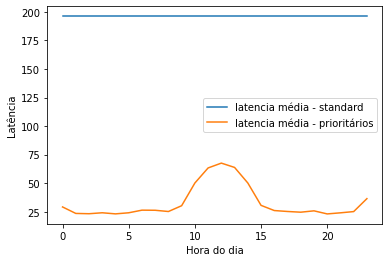

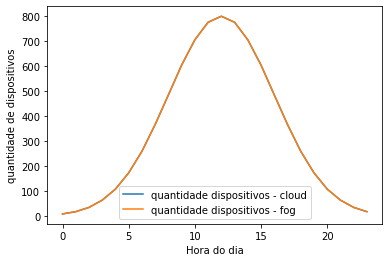

In [8]:
latency_list_fog_by_priority = []
latency_list_cloud_by_priority = []
all_devices_latency_mean_by_priority = []
num_priority_by_hour = []
num_standard_by_hour = []

for i in range(len(df_by_hour)):
    print("Hour: ", i)
    sum_smallest_latency = 0
    num_priority = 0
    num_standard = 0
    latency_by_priority = 0
    processing_nodes = utilities.instantiate_processing_nodes(1, 3)
    #######################################################
    # alocation of the devices in each region of fog node
    # ALOCATION BY PRIORITY #
    ######################################################
    latency_by_priority, cloud_latency, num_priority, num_standard = alocation_by_priority(devices_regions_by_hour[i], processing_nodes)
    #result = timeit.timeit(stmt='alocation_by_priority(devices_regions_by_hour[i], processing_nodes)', globals=globals(), number=1)
    #print("Alocation process time: ", result)

    media_priority_latency = latency_by_priority / num_priority
    media_cloud_latency = cloud_latency / num_standard
    all_devices_mean = (latency_by_priority + cloud_latency) / (num_priority + num_standard)
    
    print("Latency by priority: ", latency_by_priority, " num_priority: ", num_priority)
    print("Latencia media: ", media_priority_latency)

    print("Latency cloud: ", cloud_latency, " num_standard: ", num_standard)
    print("Latencia standard media: ", media_cloud_latency)
    latency_list_fog_by_priority.append(media_priority_latency)
    latency_list_cloud_by_priority.append(media_cloud_latency)
    all_devices_latency_mean_by_priority.append(all_devices_mean)
    num_priority_by_hour.append(num_priority)
    num_standard_by_hour.append(num_standard)

pl.plot(list(range(len(df_by_hour))), latency_list_cloud_by_priority, label="latencia média - standard")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_by_priority, label="latencia média - prioritários")
pl.xlabel("Hora do dia")
pl.ylabel("Latência")
pl.legend(['latencia média - standard', 'latencia média - prioritários'])
pl.show()

pl.plot(list(range(len(df_by_hour))), num_standard_by_hour, label="quantidade dispositivos - cloud")
pl.plot(list(range(len(df_by_hour))), num_priority_by_hour, label="quantidade dispositivos - fog")
pl.xlabel("Hora do dia")
pl.ylabel("quantidade de dispositivos")
pl.legend(['quantidade dispositivos - cloud', 'quantidade dispositivos - fog'])
pl.show()

### Alocation - Fog First

Hour:  0
numero prioritarios:  9
numero standard:  9
Latencia media prioritarios:  29.148529503164582
Latencia media standard:  20.442090871144025
Hour:  1
numero prioritarios:  18
numero standard:  18
Latencia media prioritarios:  23.47744428795359
Latencia media standard:  23.768587364445413
Hour:  2
numero prioritarios:  35
numero standard:  35
Latencia media prioritarios:  23.214493450121523
Latencia media standard:  25.132880459357146
Hour:  3
numero prioritarios:  64
numero standard:  64
Latencia media prioritarios:  24.04718543047177
Latencia media standard:  29.775920778593605
Hour:  4
numero prioritarios:  108
numero standard:  108
Latencia media prioritarios:  23.08796987371047
Latencia media standard:  26.594537856514712
Hour:  5
numero prioritarios:  173
numero standard:  173
Latencia media prioritarios:  24.04013666889976
Latencia media standard:  24.37486329448021
Hour:  6
numero prioritarios:  259
numero standard:  259
Latencia media prioritarios:  26.335405878594543
Lat

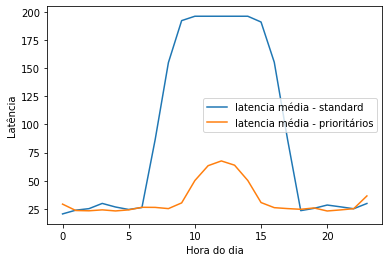

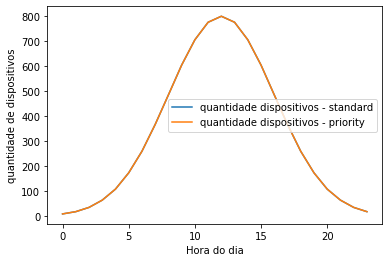

In [9]:
latency_list_fog_fog_first = []
latency_list_cloud_fog_first = []
all_devices_latency_mean_fog_first = []
num_priority_by_hour = []
num_standard_by_hour = []

for i in range(len(df_by_hour)):
    print("Hour: ", i)
    sum_smallest_latency = 0
    num_priority = 0
    num_standard = 0
    latency_by_priority = 0
    processing_nodes = utilities.instantiate_processing_nodes(1, 3)
    #########################
    # ALOCATION - FOG FIRST #
    #########################
    latency_by_priority, cloud_latency, num_priority, num_standard = fog_first_alocation(devices_regions_by_hour[i], processing_nodes)
    #result = timeit.timeit(stmt='fog_first_alocation(devices_regions_by_hour[i], processing_nodes)', globals=globals(), number=1)
    #print("Alocation process time: ", result)

    media_priority_latency = latency_by_priority / num_priority
    media_cloud_latency = cloud_latency / num_standard  
    all_devices_mean = (latency_by_priority + cloud_latency) / (num_priority + num_standard)
    
    print("Latencia media prioritarios: ", media_priority_latency)
    print("Latencia media standard: ", media_cloud_latency)
    latency_list_fog_fog_first.append(media_priority_latency)
    latency_list_cloud_fog_first.append(media_cloud_latency)
    all_devices_latency_mean_fog_first.append(all_devices_mean)
    num_priority_by_hour.append(num_priority)
    num_standard_by_hour.append(num_standard)

pl.plot(list(range(len(df_by_hour))), latency_list_cloud_fog_first, label="latencia média - standard")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_fog_first, label="latencia média - prioritários")
pl.xlabel("Hora do dia")
pl.ylabel("Latência")
pl.legend(['latencia média - standard', 'latencia média - prioritários'])
pl.show()

pl.plot(list(range(len(df_by_hour))), num_standard_by_hour, label="quantidade dispositivos - cloud")
pl.plot(list(range(len(df_by_hour))), num_priority_by_hour, label="quantidade dispositivos - fog")
pl.xlabel("Hora do dia")
pl.ylabel("quantidade de dispositivos")
pl.legend(['quantidade dispositivos - standard', 'quantidade dispositivos - priority'])
pl.show()

### Alocation - Only Cloud

Hour:  0
Latency by priority:  1765.7694  num_priority:  9
Latencia media:  196.1966
Latency cloud:  1765.7694  num_standard:  9
Latencia standard media:  196.1966
Latencia media:  196.1966
Hour:  1
Latency by priority:  3531.538800000001  num_priority:  18
Latencia media:  196.19660000000007
Latency cloud:  3531.538800000001  num_standard:  18
Latencia standard media:  196.19660000000007
Latencia media:  196.19660000000007
Hour:  2
Latency by priority:  6866.881000000005  num_priority:  35
Latencia media:  196.19660000000013
Latency cloud:  6866.881000000005  num_standard:  35
Latencia standard media:  196.19660000000013
Latencia media:  196.19660000000013
Hour:  3
Latency by priority:  12556.58239999999  num_priority:  64
Latencia media:  196.19659999999985
Latency cloud:  12556.58239999999  num_standard:  64
Latencia standard media:  196.19659999999985
Latencia media:  196.19659999999985
Hour:  4
Latency by priority:  21189.23279999996  num_priority:  108
Latencia media:  196.196599

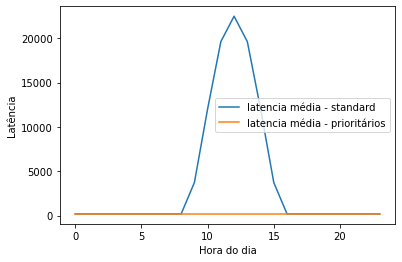

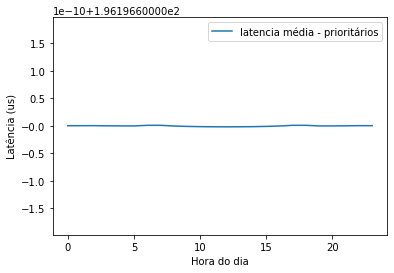

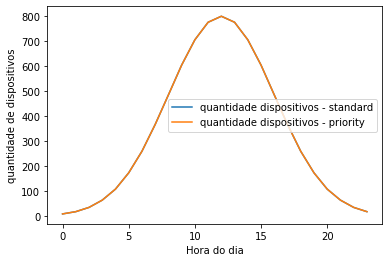

In [10]:
latency_list_fog_only_cloud = []
latency_list_cloud_only_cloud = []
all_devices_latency_mean_only_cloud = []
num_priority_by_hour = []
num_standard_by_hour = []

for i in range(len(df_by_hour)):
    print("Hour: ", i)
    sum_smallest_latency = 0
    num_priority = 0
    num_standard = 0
    latency_by_priority = 0
    cloud_latency = 0
    processing_nodes = utilities.instantiate_processing_nodes(1, 3)
    ##########################
    # ALOCATION - ONLY CLOUD #
    ##########################
    latency_by_priority, cloud_latency, num_priority, num_standard = alocation_cloud_only(devices_regions_by_hour[i], processing_nodes)
    #result = timeit.timeit(stmt='alocation_cloud_only(devices_regions_by_hour[i], processing_nodes)', globals=globals(), number=1)
    #print("Alocation process time: ", result)


    media_priority_latency = latency_by_priority / num_priority
    media_cloud_latency = cloud_latency / num_standard
    all_devices_mean = (latency_by_priority + cloud_latency) / (num_priority + num_standard)
    
    print("Latency by priority: ", latency_by_priority, " num_priority: ", num_priority)
    print("Latencia media: ", media_priority_latency)

    print("Latency cloud: ", cloud_latency, " num_standard: ", num_standard)
    print("Latencia standard media: ", media_cloud_latency)
    
    print("Latencia media: ", media_priority_latency)
    latency_list_fog_only_cloud.append(media_priority_latency)
    latency_list_cloud_only_cloud.append(media_cloud_latency)
    all_devices_latency_mean_only_cloud.append(all_devices_mean)
    num_priority_by_hour.append(num_priority)
    num_standard_by_hour.append(num_standard)

pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_cloud, label="latencia média - standard")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_cloud, label="latencia média - prioritários")
pl.xlabel("Hora do dia")
pl.ylabel("Latência")
pl.legend(['latencia média - standard', 'latencia média - prioritários'])
pl.show()

pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_cloud, label="latencia média - prioritários")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend(['latencia média - prioritários'])
pl.show()

pl.plot(list(range(len(df_by_hour))), num_standard_by_hour, label="quantidade dispositivos - fila")
pl.plot(list(range(len(df_by_hour))), num_priority_by_hour, label="quantidade dispositivos - cloud")
pl.xlabel("Hora do dia")
pl.ylabel("quantidade de dispositivos")
pl.legend(['quantidade dispositivos - standard', 'quantidade dispositivos - priority'])
pl.show()

### Alocation - Only Fog

Hour:  0
############ FOGS ############
fog 0 connected:  4
fog 0 queue:  0
fog 1 connected:  3
fog 1 queue:  0
fog 2 connected:  11
fog 2 queue:  0
Latency by priority:  262.33676552848124  num_priority:  9
Latencia media:  29.148529503164582
Latency cloud:  183.97881784029622  num_standard:  9
Latencia standard media:  20.442090871144025
Latencia media:  29.148529503164582
Hour:  1
############ FOGS ############
fog 0 connected:  11
fog 0 queue:  0
fog 1 connected:  13
fog 1 queue:  0
fog 2 connected:  12
fog 2 queue:  0
Latency by priority:  422.59399718316456  num_priority:  18
Latencia media:  23.47744428795359
Latency cloud:  427.8345725600174  num_standard:  18
Latencia standard media:  23.768587364445413
Latencia media:  23.47744428795359
Hour:  2
############ FOGS ############
fog 0 connected:  26
fog 0 queue:  0
fog 1 connected:  14
fog 1 queue:  0
fog 2 connected:  30
fog 2 queue:  0
Latency by priority:  812.5072707542533  num_priority:  35
Latencia media:  23.2144934501215

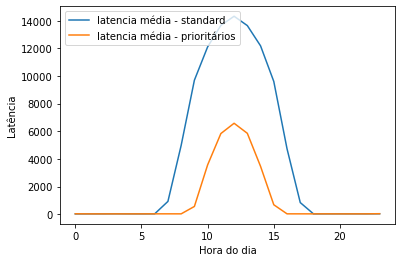

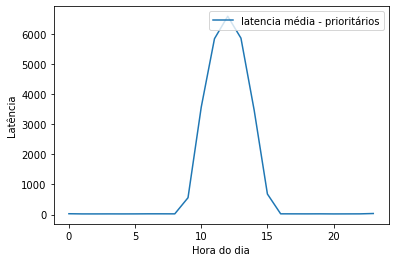

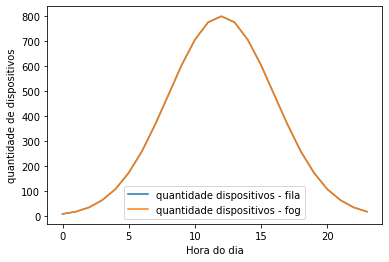

In [11]:
latency_list_fog_only_fog = []
latency_list_cloud_only_fog = []
all_devices_latency_mean_only_fog = []
num_priority_by_hour = []
num_standard_by_hour = []

for i in range(len(df_by_hour)):
    print("Hour: ", i)
    sum_smallest_latency = 0
    num_priority = 0
    num_standard = 0
    latency_by_priority = 0
    processing_nodes = utilities.instantiate_processing_nodes(1, 3)
    ########################
    # ALOCATION - ONLY FOG #
    ########################
    latency_by_priority, cloud_latency, num_priority, num_standard = alocation_fog_only(devices_regions_by_hour[i], processing_nodes)
    #result = timeit.timeit(stmt='alocation_fog_only(devices_regions_by_hour[i], processing_nodes)', globals=globals(), number=1)
    #print("Alocation process time: ", result)

    media_priority_latency = latency_by_priority / num_priority
    media_cloud_latency = cloud_latency / num_standard
    all_devices_mean = (latency_by_priority + cloud_latency) / (num_priority + num_standard)

    print("Latency by priority: ", latency_by_priority, " num_priority: ", num_priority)
    print("Latencia media: ", media_priority_latency)

    print("Latency cloud: ", cloud_latency, " num_standard: ", num_standard)
    print("Latencia standard media: ", media_cloud_latency)
    
    print("Latencia media: ", media_priority_latency)
    latency_list_fog_only_fog.append(media_priority_latency)
    latency_list_cloud_only_fog.append(media_cloud_latency)
    all_devices_latency_mean_only_fog.append(all_devices_mean)
    num_priority_by_hour.append(num_priority)
    num_standard_by_hour.append(num_standard)

pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_fog, label="latencia média - standard")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_fog, label="latencia média - prioritários")
pl.xlabel("Hora do dia")
pl.ylabel("Latência")
pl.legend(['latencia média - standard', 'latencia média - prioritários'])
pl.show()

pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_fog, label="latencia média - prioritários")
pl.xlabel("Hora do dia")
pl.ylabel("Latência")
pl.legend(['latencia média - prioritários'])
pl.show()

pl.plot(list(range(len(df_by_hour))), num_standard_by_hour, label="quantidade dispositivos - fila")
pl.plot(list(range(len(df_by_hour))), num_priority_by_hour, label="quantidade dispositivos - fog")
pl.xlabel("Hora do dia")
pl.ylabel("quantidade de dispositivos")
pl.legend(['quantidade dispositivos - fila', 'quantidade dispositivos - fog'])
pl.show()

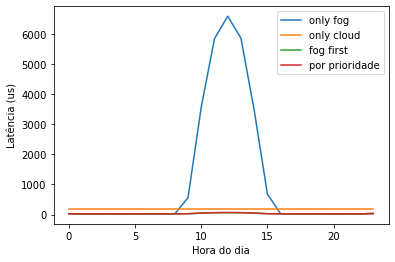

In [12]:
pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_fog, label="latencia média - only_fog")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_cloud, label="latencia média - only cloud")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_fog_first, label="latencia média - fog first")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_by_priority, label="latencia média - por CoS")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend(['only fog', 'only cloud', 'fog first', 'por CoS'])
pl.show()

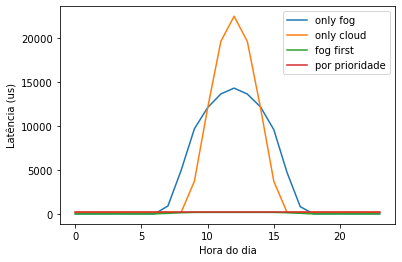

In [13]:
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_fog, label="latencia média - only_fog")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_cloud, label="latencia média - only cloud")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_fog_first, label="latencia média - fog first")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_by_priority, label="latencia média - por CoS")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend(['only fog', 'only cloud', 'fog first', 'por CoS'])
pl.show()

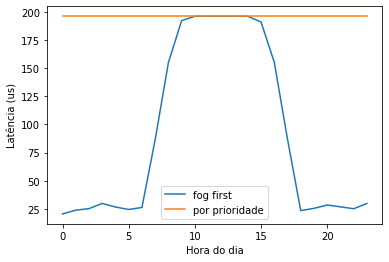

In [14]:
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_fog_first, label="latencia média - fog first")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_by_priority, label="latencia média - por CoS")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend(['fog first', 'por CoS'])
pl.show()

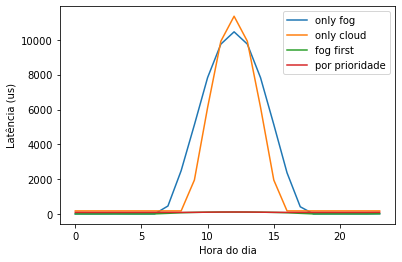

In [15]:
pl.plot(list(range(len(df_by_hour))), all_devices_latency_mean_only_fog, label="latencia média - only_fog")
pl.plot(list(range(len(df_by_hour))), all_devices_latency_mean_only_cloud, label="latencia média - only cloud")
pl.plot(list(range(len(df_by_hour))), all_devices_latency_mean_fog_first, label="latencia média - fog first")
pl.plot(list(range(len(df_by_hour))), all_devices_latency_mean_by_priority, label="latencia média - por CoS")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend(['only fog', 'only cloud', 'fog first', 'por CoS'])
pl.show()

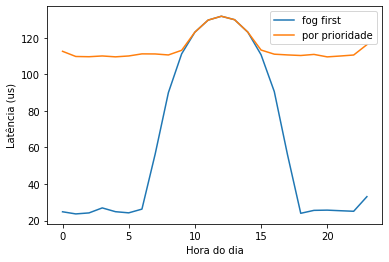

In [16]:
pl.plot(list(range(len(df_by_hour))), all_devices_latency_mean_fog_first, label="latencia média - fog first")
pl.plot(list(range(len(df_by_hour))), all_devices_latency_mean_by_priority, label="latencia média - por CoS")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend(['fog first', 'por CoS'])
pl.show()

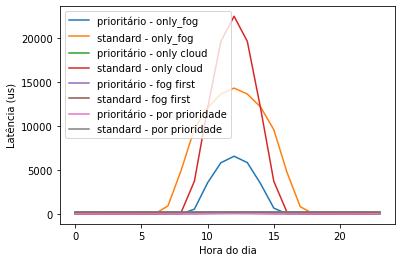

In [17]:
pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_fog, label="latencia média | prioritário - only_fog")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_fog, label="latencia média | standard - only_fog")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_cloud, label="latencia média | prioritário - only cloud")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_cloud, label="latencia média | standard - only cloud")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_fog_first, label="latencia média | prioritário - fog first")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_fog_first, label="latencia média | standard - fog first")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_by_priority, label="latencia média | prioritário - por CoS")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_by_priority, label="latencia média | standard - por CoS")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend(['prioritário - only_fog',
            'standard - only_fog',
            'prioritário - only cloud',
            'standard - only cloud',
            'prioritário - fog first', 
            'standard - fog first', 
            'prioritário - por CoS',
            'standard - por CoS'])
pl.show()

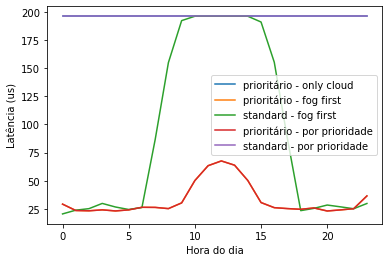

In [18]:
#pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_fog, label="latencia média | prioritário - only_fog")
#pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_fog, label="latencia média | standard - only_fog")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_only_cloud, label="latencia média | prioritário - only cloud")
#pl.plot(list(range(len(df_by_hour))), latency_list_cloud_only_cloud, label="latencia média | standard - only cloud")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_fog_first, label="latencia média | prioritário - fog first")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_fog_first, label="latencia média | standard - fog first")
pl.plot(list(range(len(df_by_hour))), latency_list_fog_by_priority, label="latencia média | prioritário - por CoS")
pl.plot(list(range(len(df_by_hour))), latency_list_cloud_by_priority, label="latencia média | standard - por CoS")
pl.xlabel("Hora do dia")
pl.ylabel("Latência (us)")
pl.legend([#'prioritário - only_fog',
#            'standard - only_fog',
            'prioritário - only cloud',
#            'standard - only cloud',
            'prioritário - fog first', 
            'standard - fog first', 
            'prioritário - por CoS',
            'standard - por CoS'])
pl.show()